In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [6]:
# My data is in google drive.
train_dir ="drive/My Drive/crop_potato_tomato/train_set/"
test_dir="drive/My Drive/crop_potato_tomato/test_set/"

In [7]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count    

In [8]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) # For testing i took only few samples from unseen data. we can evaluate using validation data which is part of train data.
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

13 Classes
14537 Train images
3637 Test images


In [9]:
# Preprocessing data.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [10]:
# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 14536 images belonging to 13 classes.
Found 3637 images belonging to 13 classes.


In [11]:
# The name of the 12 diseases.
train_generator.class_indices

{'Potato___Early_blight': 0,
 'Potato___Late_blight': 1,
 'Potato___healthy': 2,
 'Tomato_Bacterial_spot': 3,
 'Tomato_Early_blight': 4,
 'Tomato_Late_blight': 5,
 'Tomato_Leaf_Mold': 6,
 'Tomato_Septoria_leaf_spot': 7,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 8,
 'Tomato__Target_Spot': 9,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 10,
 'Tomato__Tomato_mosaic_virus': 11,
 'Tomato_healthy': 12}

In [12]:
# CNN building.
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23104)            

In [13]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'flatten_1', 'dense_1', 'dropout_1', 'dense_2', 'dense_3']


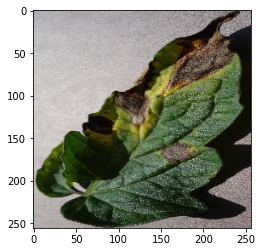

In [16]:
# Take one image to visualize it's changes after every layer
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('/content/drive/My Drive/crop_potato_tomato/train_set/Tomato_Early_blight/8a1d3598-cd1d-4978-9e18-b5e205108540___RS_Erly.B 8315.JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('/content/drive/My Drive/crop_potato_tomato/train_set/Tomato_Early_blight/8a1d3598-cd1d-4978-9e18-b5e205108540___RS_Erly.B 8315.JPG', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [17]:
# Visualizing output after every layer.
from keras.models import Model
conv2d_1_output = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)
max_pooling2d_1_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_1').output)
conv2d_2_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
max_pooling2d_2_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_2').output)
conv2d_3_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_3').output)
max_pooling2d_3_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_3').output)
flatten_1_output = Model(inputs=model.input,outputs=model.get_layer('flatten_1').output)
conv2d_1_features = conv2d_1_output.predict(img)
max_pooling2d_1_features = max_pooling2d_1_output.predict(img)
conv2d_2_features = conv2d_2_output.predict(img)
max_pooling2d_2_features = max_pooling2d_2_output.predict(img)
conv2d_3_features = conv2d_3_output.predict(img)
max_pooling2d_3_features = max_pooling2d_3_output.predict(img)
flatten_1_features = flatten_1_output.predict(img)

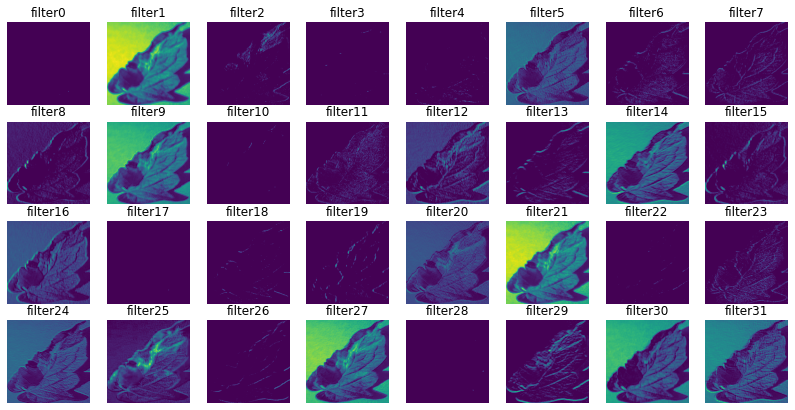

In [18]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis') # Visualizing in color mode.
plt.show()

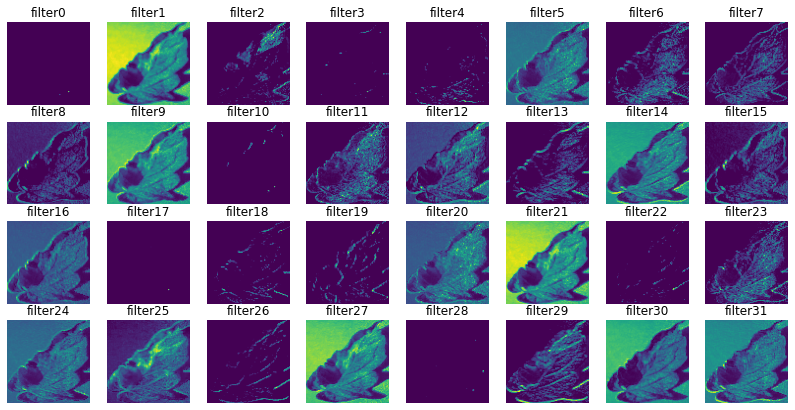

In [20]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_1_features[0, :, :, i], cmap='viridis')
plt.show()


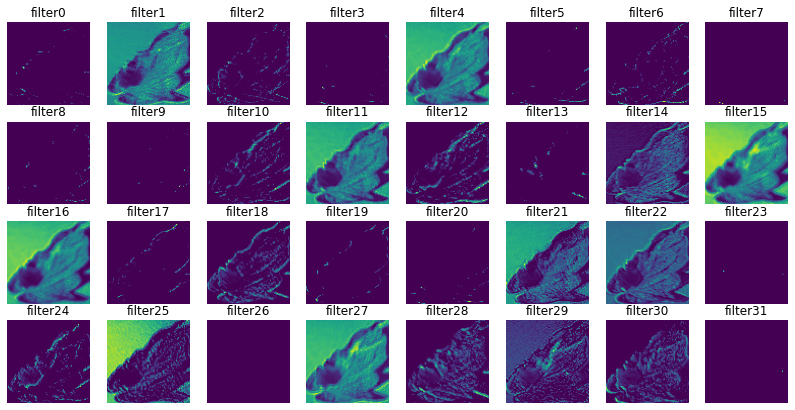

In [21]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_2_features[0, :, :, i], cmap='viridis')
plt.show()

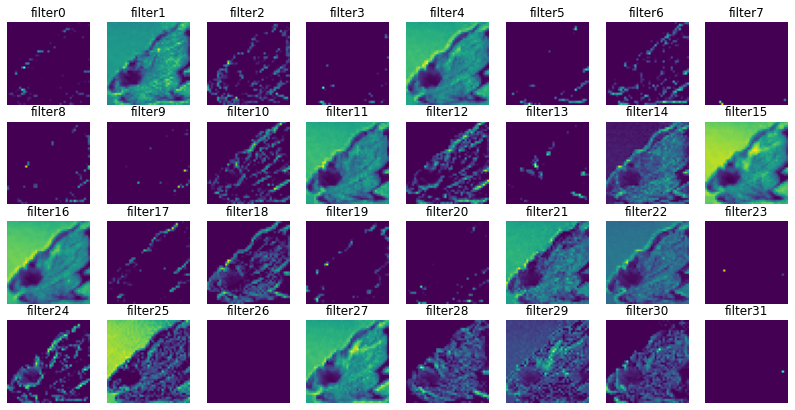

In [22]:
# we can also visualize in color mode.
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_2_features[0, :, :, i], cmap='viridis') 
plt.show()

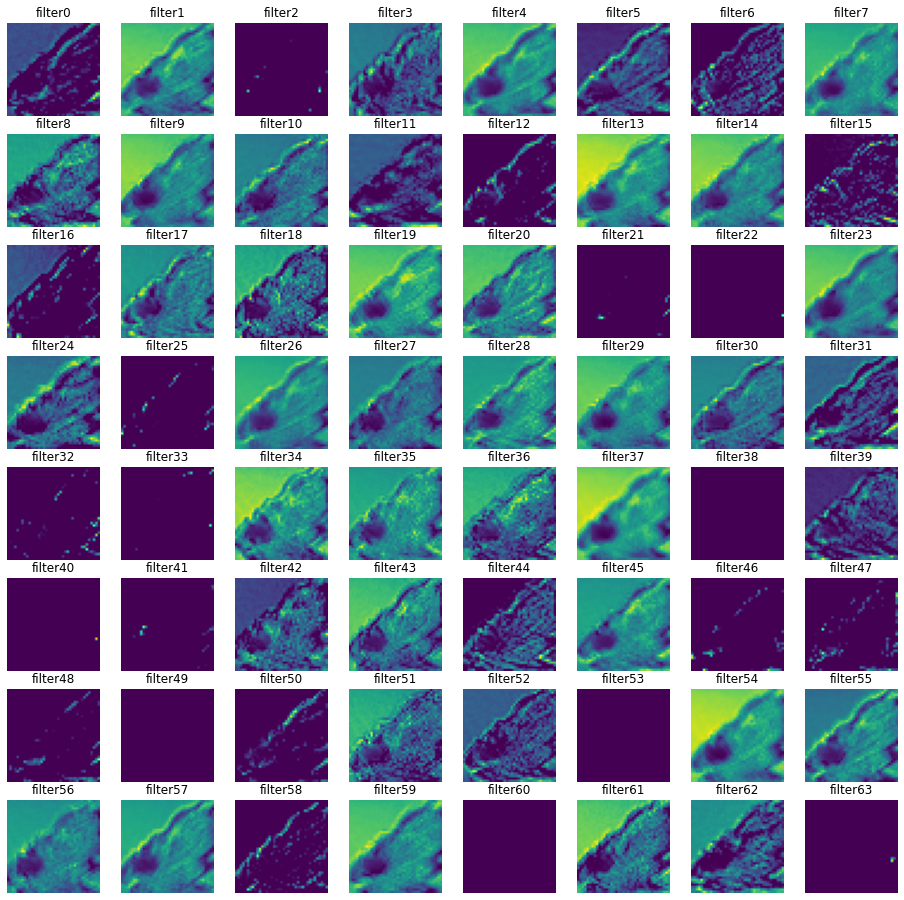

In [23]:

import matplotlib.image as mpimg

fig=plt.figure(figsize=(16,16))
columns =8 
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_3_features[0, :, :, i], cmap='viridis')
plt.show()

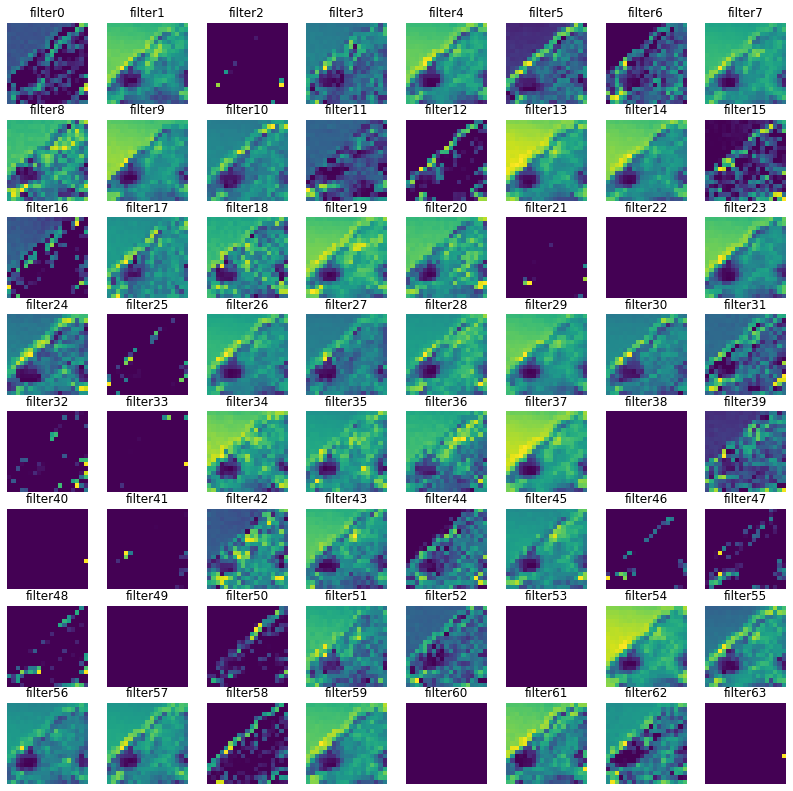

In [24]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,14))
columns = 8
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_3_features[0, :, :, i],cmap='viridis')
plt.show()

In [25]:
# validation data.
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 14536 images belonging to 13 classes.


In [28]:
# Model building to get trained with parameters.
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,
                          nb_epoch=15,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          nb_val_samples= validation_generator.samples// batch_size,verbose=1)

Epoch 1/15
454/454 [==============================] - 2572s 6s/step - loss: 0.9276 - accuracy: 0.6917 - val_loss: 0.3399 - val_accuracy: 0.7928
Epoch 2/15
454/454 [==============================] - 418s 922ms/step - loss: 0.6352 - accuracy: 0.7806 - val_loss: 0.2410 - val_accuracy: 0.8536
Epoch 3/15
454/454 [==============================] - 418s 920ms/step - loss: 0.4876 - accuracy: 0.8323 - val_loss: 0.2274 - val_accuracy: 0.8332
Epoch 4/15
454/454 [==============================] - 417s 919ms/step - loss: 0.3940 - accuracy: 0.8649 - val_loss: 0.2400 - val_accuracy: 0.9072
Epoch 5/15
454/454 [==============================] - 417s 918ms/step - loss: 0.3712 - accuracy: 0.8709 - val_loss: 0.1746 - val_accuracy: 0.9086
Epoch 6/15
454/454 [==============================] - 418s 920ms/step - loss: 0.3342 - accuracy: 0.8854 - val_loss: 0.1346 - val_accuracy: 0.9308
Epoch 7/15
454/454 [==============================] - 418s 921ms/step - loss: 0.2794 - accuracy: 0.9030 - val_loss: 0.4061 - v

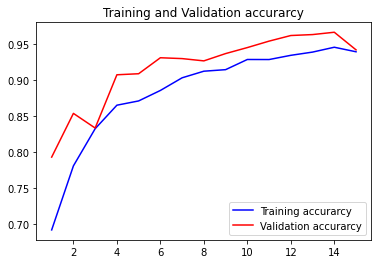

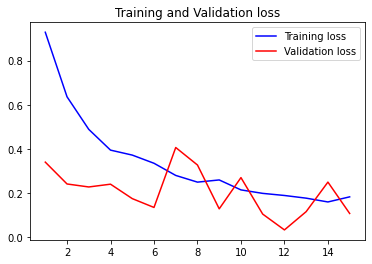

In [31]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [32]:
score,accuracy =model.evaluate(test_generator,verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {}".format(accuracy))

114/114 [==============================] - 903s 8s/step
Test score is 0.4473431408405304
Test accuracy is 0.8702226877212524


In [82]:
# Save entire model with optimizer, architecture, weights and training configuration.
from keras.models import load_model
model.save('crop.hdf5')

In [34]:
# Save model weights.
from keras.models import load_model
model.save_weights('crop_weights.h5')

In [35]:

# Get classes of model trained on
classes = train_generator.class_indices 
classes

{'Potato___Early_blight': 0,
 'Potato___Late_blight': 1,
 'Potato___healthy': 2,
 'Tomato_Bacterial_spot': 3,
 'Tomato_Early_blight': 4,
 'Tomato_Late_blight': 5,
 'Tomato_Leaf_Mold': 6,
 'Tomato_Septoria_leaf_spot': 7,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 8,
 'Tomato__Target_Spot': 9,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 10,
 'Tomato__Tomato_mosaic_virus': 11,
 'Tomato_healthy': 12}

In [38]:
# Loading model and predict.
from keras.models import load_model
model=load_model('crop.h5')

Classes = ["Potato___Early_blight","Potato___Late_blight","Potato___healthy","Tomato___Bacterial_spot","Tomato___Early_blight",
           "Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite",
           "Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___healthy"]

Potato___healthy


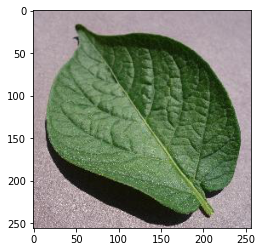

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=256
img_height=256
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/drive/My Drive/crop_potato_tomato/test_set/Potato___healthy/0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817.JPG')])
disease=image.load_img('/content/drive/My Drive/crop_potato_tomato/test_set/Potato___healthy/0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817.JPG')
plt.imshow(disease)
print (Classes[int(result)])